In [1]:
%load_ext pretty_jupyter

In [2]:
import patsy as pa
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np

tfd = tfp.distributions

from MakeMyPrior.elicitation_wrapper import expert_model
from MakeMyPrior.training import trainer
from MakeMyPrior.helper_functions import group_obs, Exponential_unconstrained, Normal_unconstrained
from MakeMyPrior.user_config import target_config, target_input
from MakeMyPrior.helper_functions import print_restab, plot_priors_hyp, plot_expert_preds, group_stats, plot_priors_flow
import MakeMyPrior.combine_losses 

from tabulate import tabulate
import pprint
pp = pprint.PrettyPrinter(depth=4)

tf.random.set_seed(2024)

C:\Users\flobo\anaconda3\envs\make-my-prior\Lib\site-packages\bayesflow\trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


# Background: Case Study
We focus on an experiment conducted by Unkelbach & Rom (2020)[REF], where participants are presented with general knowledge statements in two consecutive phases. During the second phase, they are required to indicate whether each statement is true or false. The response variable of interest is the proportion of true judgments (PTJs). The main objective of the study is to investigate the influence of two factors on PTJs: (1) repetition (ReP), which involves presenting some statements from the first phase again in the second phase, and (2) encoding depth (EnC), where participants are divided into groups varying in the level of elaboration required for initial sentence processing in the first phase. We consider a 2 (ReP:repeated, new) $\times$ 3 (EnC: shallow, standard, deep) between-subject factorial design with treatment contrasts used for both factors. The baseline levels are set as new for ReP and deep for EnC. 
## Data generating model
\begin{align*}
    y_i &\sim \text{Normal}(\theta_i, s)\\
    \theta_i &= \beta_0 + \beta_1x_1 + \beta_2x_2 + \beta_3x_3 + \beta_4x_4 + \beta_5x_5\\
    \beta_k &\sim \text{Normal}(\mu_k, \sigma_k) \quad \text{for }k=0,\ldots, 5\\
    s &\sim \text{Exponential}(\nu)
\end{align*}
Here, $𝑦_𝑖$ represents the responses for each observation $𝑖 = 1, \ldots , 𝑁$, assumed to follow a normal distribution with mean $\theta_𝑖$ and standard deviation $𝑠$. The expected value $\theta_𝑖$ is modeled as a linear function of two categorical predictors, ReP and EnC. The regression coefficients $\beta_𝑘$ for $𝑘 = 0, \ldots , 5$ are assigned normal prior distributions. Specifically, $\beta_0$ represents the PTJs for condition new-deep, while $\beta_1$ represents the difference in PTJs ($\Delta$PTJ) between repeated and new statements. Additionally, $\beta_2$ captures the $\Delta$PTJ for new statements in the shallow- vs. standard-encoding condition, $\beta_3$ represents the $\Delta$PTJ for new statements in the shallow- vs. deep-encoding condition, and $\beta_4$ and $\beta_5$ account for the interaction effects between ReP and EnC. The standard deviation 𝑠 of the normal likelihood follows an Exponential prior distribution with rate parameter $\nu$.

# Methodology: Workflow
[//]: # (-.- .tabset)

+ For each mini-batch:
    + $i$ observations with $i = 1, \ldots, N$, 
    + $k$ regression coefficients with $k = 0,\ldots,6$,
    + $s$ samples from each prior distribution with $s=1,\ldots, M$
    + $g$ group means with $g = 1,\ldots,6$ (corresponding to a $2 \times 3$ factorial design
 
+ General procedure:
    + Draw samples from prior distribution(s) of model parameters 
    + Generate prior predictions according to the data generating model
    + Compute the pre-defined target quantities
    + Compute the elicited statistics of the target quantities
    + Measure the discrepancy between the model-implied and the expert elicited statistics
    + Update the weights of the transformation function of the normalizing flow  

## Method: Normalizing Flow
[//]: # (-.- .tabset)

### Method specification
+ PriorSamples($\lambda$):
\begin{align*}
(\{\beta_k\}_s,\{s\}_s) &\sim p_\phi(\lambda)\\
\end{align*}
+ Generator($\beta_k, s$):
\begin{align*}
\{\theta_i\}_s &= \{\beta_k\}_s \times X_i\\
\bar{s} &= \frac{1}{M} \sum_{i=1}^M \{s\}_s\\
\{y_i\}_s &\sim \text{Normal}(\{\theta_i\}_s, \bar{s})\\
\end{align*}
+ Targets($\{y_i\}_s$):
\begin{align*}
\{\bar{y}_{g}\}_s &= \frac{1}{N_{g}} \sum_{i=1}^{N_{g}} \{y_i\}_s \quad \text{ for } g = 1,\ldots,6\\
\{\Delta_{eff}\}_s &= \{\bar{y}_{g1}\}_s - \{\bar{y}_{g2}\}_s \quad \text{ for } g1 = 3,4,5 \text{ and } g2 = 0,1,2\\
\{R^2\}_s &= \frac{Var(\{\theta_i\}_s)}{Var(\{y_i\}_s)} 
\end{align*}
+ Elicits($\{\bar{y}_{g}\}_s, \{\Delta_{eff}\}_s, \{R^2\}_s$)
\begin{align*}
\text{Quantile-based:} \quad &Q_p^{g} = Q_{p}^{g} \{y_i\}_s \quad \text{ for } g = 1,\ldots, 6, p = 0.1, \ldots, 0.9\\
\text{Quantile-based:} \quad &Q_p^{eff} = Q_{p}^{eff} \{\Delta_{eff}\}_s \quad \text{ for } eff = 1,2,3; p = 0.1, \ldots, 0.9\\
\text{Histogram-based:} \quad &\{R^2\}_s =\{R^2\}_s 
\end{align*}

### User specification

#### Setting hyperparameter for the learning algorithm

In [3]:
# -.-|m { input: true, output_error: false, input_fold: show }

# setting of hyperparameter of learning algorithm
user_config = dict(                    
        B = 2**8,                          
        rep = 200,                         
        epochs = 300,                      
        view_ep = 30,
        lr_decay = True,
        lr0 = 0.001, 
        lr_min = 0.000001, 
        loss_dimensions = "m,n:B",   
        loss_discrepancy = "energy",       
        loss_scaling = "unscaled",         
        method = "normalizing_flow"  
        )

#### Define the design matrix

In [4]:
# construct design matrix
X =  pa.dmatrix("a*b", pa.balanced(a = 2, b = 3, repeat = 60), return_type="dataframe")
dmatrix = tf.cast(X, dtype = tf.float32)
# extract contrast matrix from design matrix (for allocating observations to groups)
cmatrix = dmatrix[0:dmatrix.shape[1], :]

print(X)

     Intercept  a[T.a2]  b[T.b2]  b[T.b3]  a[T.a2]:b[T.b2]  a[T.a2]:b[T.b3]
0          1.0      0.0      0.0      0.0              0.0              0.0
1          1.0      0.0      1.0      0.0              0.0              0.0
2          1.0      0.0      0.0      1.0              0.0              0.0
3          1.0      1.0      0.0      0.0              0.0              0.0
4          1.0      1.0      1.0      0.0              1.0              0.0
..         ...      ...      ...      ...              ...              ...
355        1.0      0.0      1.0      0.0              0.0              0.0
356        1.0      0.0      0.0      1.0              0.0              0.0
357        1.0      1.0      0.0      0.0              0.0              0.0
358        1.0      1.0      1.0      0.0              1.0              0.0
359        1.0      1.0      0.0      1.0              0.0              1.0

[360 rows x 6 columns]


#### Setup the 'ideal agent'
Define an 'arbitrary' ground truth for the hyperparameter values for method validation.

In [5]:
# true hyperparameter values for ideal_expert
true_values = dict()
true_values["mu"] = [0.12, 0.15, -0.02, -0.03, -0.02, -0.04]
true_values["sigma"] = [0.02, 0.02, 0.06, 0.06, 0.03, 0.03]
true_values["nu"] = 9.

# model parameters
parameters_dict = dict()
for i in range(6):
    parameters_dict[f"beta_{i}"] = {
            "true": tfd.Normal(true_values["mu"][i], true_values["sigma"][i]),
            "initialization": [tfd.Normal(0.,0.1)]*2
            }

parameters_dict["sigma"] = {
        "true": tfd.Exponential(true_values["nu"]),
        "initialization": [tfd.Normal(0.,0.1)]
        }

print("True hyperparameter values:")
pp.pprint(true_values)

True hyperparameter values:
{'mu': [0.12, 0.15, -0.02, -0.03, -0.02, -0.04],
 'nu': 9.0,
 'sigma': [0.02, 0.02, 0.06, 0.06, 0.03, 0.03]}


#### Define the data generating model

In [6]:
# -.-|m { input: true, output_error: false, input_fold: show }

# generative model
class GenerativeModel(tf.Module):
    def __call__(self, 
                 parameters, # obligatory: samples from prior distributions; tf.Tensor
                 dmatrix,    # optional: design matrix; tf.Tensor
                 cmatrix,    # optional: contrast matrix; tf.Tensor
                 **kwargs    # obligatory: possibility for further keyword arguments is needed 
                 ):  

        # transformed sigma parameter
        sigma_avg = tf.math.reduce_mean(tf.exp(parameters[:,:,-1]), axis = 1)[:,None,None]
        
        # compute linear predictor term
        epred = parameters[:,:,0:6] @ tf.transpose(dmatrix)
        
        # define likelihood
        likelihood = tfd.Normal(
            loc = epred, 
            scale = tf.broadcast_to(sigma_avg, shape = epred.shape)
        )
        
        # sample prior predictive data
        ypred = likelihood.sample()
        
        # compute custom target quantity (here: group-differences)
        samples_grouped = group_obs(ypred, dmatrix, cmatrix)

        # compute mean difference between groups
        effect_list = []
        diffs = [(3,0), (4,1), (5,2)]
        for i in range(len(diffs)):
            # compute group difference
            diff = tf.math.subtract(
                samples_grouped[:, :, :, diffs[i][0]],
                samples_grouped[:, :, :, diffs[i][1]]
            )
            # average over individual obs within each group
            diff_mean = tf.reduce_mean(diff, axis=2)
            # collect all mean group differences
            effect_list.append(diff_mean)

        mean_effects = tf.stack(effect_list, axis=-1)
        
        return dict(likelihood = likelihood,      # obligatory: likelihood; callable
                    ypred = ypred,                # obligatory: prior predictive data
                    epred = epred,                # obligatory: samples from linear predictor
                    mean_effects = mean_effects,   # optional: custom target quantity
                    )

#### Specify the target quantities and the elicitation technique

In [7]:
 # define a custom function using the output from the generative model   
def custom_r2(ypred, epred, **kwargs):
    return tf.math.divide(tf.math.reduce_variance(epred, axis = -1), 
                          tf.math.reduce_variance(ypred, axis = -1))

# specify target quantity, elicitation technique and loss combination
t1 = target_config(target="R2", 
                   elicitation="histogram",
                   combine_loss="all",
                   custom_target_function = custom_r2)
t2 = target_config(target="group_means", 
                   elicitation="quantiles", 
                   combine_loss="by-group", 
                   quantiles_specs = (10, 20, 30, 40, 50, 60, 70, 80, 90))
t3 = target_config(target="mean_effects", 
                   elicitation="quantiles",
                   combine_loss="by-group",
                   quantiles_specs = (10, 20, 30, 40, 50, 60, 70, 80, 90))

target_info = target_input(t1, t2, t3)

pp.pprint(target_info)

{'combine_loss': ['all', 'by-group', 'by-group'],
 'custom_target_function': [<function custom_r2 at 0x0000024BB5197D80>,
                            None,
                            None],
 'elicitation': ['histogram', 'quantiles', 'quantiles'],
 'internal_loss': [None, None, None],
 'quantiles_specs': [(10, 20, 30, 40, 50, 60, 70, 80, 90),
                     (10, 20, 30, 40, 50, 60, 70, 80, 90)],
 'target': ['R2', 'group_means', 'mean_effects']}


### Simulate from the "ideal" expert

In [8]:
# -.-|m { input: true, output_error: false, input_fold: show }

expert_res_list, prior_pred_res = expert_model(1, user_config["rep"],
                                   parameters_dict, GenerativeModel, target_info,
                                   method = "ideal_expert_nf",
                                   dmatrix = dmatrix,
                                   cmatrix = cmatrix,
                                   dmatrix_fct = dmatrix)

# elicited statistics from the (ideal) expert
expert_res_list.keys()

dict_keys(['R2_hist_0', 'group_means_quant_1', 'mean_effects_quant_2'])

#### Expert predictions

In [9]:
# group means
print(group_stats(prior_pred_res["ypred"], num_groups = 6))
# mean effects
print("mean effects:")
print(np.round(tf.reduce_mean(prior_pred_res["mean_effects"],(0,1)),2))

+-------+------+------+
| group | mean | std  |
+-------+------+------+
|  gr_0 | 0.12 | 0.02 |
|  gr_1 | 0.1  | 0.06 |
|  gr_2 | 0.09 | 0.07 |
|  gr_3 | 0.27 | 0.03 |
|  gr_4 | 0.22 | 0.07 |
|  gr_5 | 0.2  | 0.08 |
+-------+------+------+
mean effects:
[0.15 0.13 0.11]


C:\Users\flobo\MakeMyPrior\MakeMyPrior\helper_functions.py:417: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels(["r","new: deep","new: standard","new: shallow","rep: deep","rep: standard","rep: shallow"])


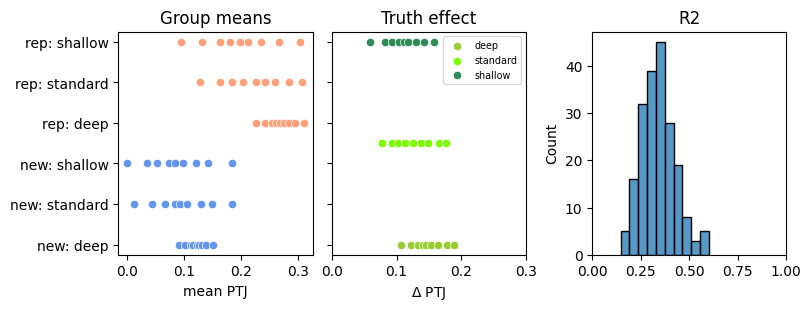

In [10]:
# plot expert predictions
plot_expert_preds(expert_res_list)

### Learn the prior distributions

In [11]:
res_dict = trainer(expert_res_list, user_config["B"], user_config["rep"],
                   parameters_dict, user_config["method"], GenerativeModel,
                   target_info, user_config, loss_balancing = True, save_vals = ["prior_preds"],
                   dmatrix = dmatrix, cmatrix = cmatrix, dmatrix_fct = dmatrix)

epoch_time: 1117.474ms
Epoch: 0, loss: 0.76864, lr: 0.001000
epoch_time: 304.150ms
Epoch: 30, loss: 0.02586, lr: 0.000531
epoch_time: 268.193ms
Epoch: 60, loss: 0.01175, lr: 0.000282
epoch_time: 283.451ms
Epoch: 90, loss: 0.00847, lr: 0.000150
epoch_time: 289.710ms
Epoch: 120, loss: 0.00889, lr: 0.000080
epoch_time: 275.654ms
Epoch: 150, loss: 0.00839, lr: 0.000042
epoch_time: 268.742ms
Epoch: 180, loss: 0.00846, lr: 0.000023
epoch_time: 277.343ms
Epoch: 210, loss: 0.00893, lr: 0.000012
epoch_time: 266.057ms
Epoch: 240, loss: 0.00814, lr: 0.000006
epoch_time: 258.379ms
Epoch: 270, loss: 0.00922, lr: 0.000003


### Results

#### Loss function

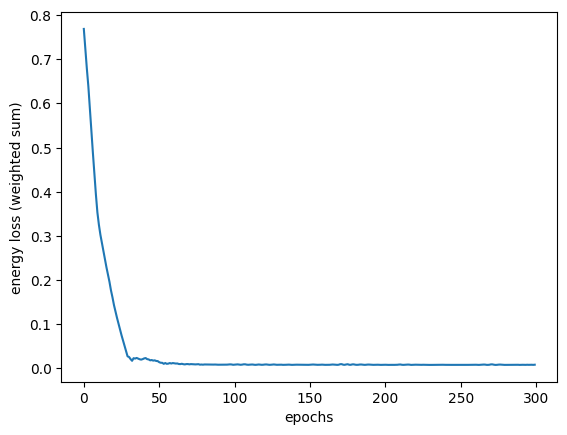

In [12]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(len(res_dict["loss_info"])), res_dict["loss_info"]) 
plt.xlabel("epochs")
plt.ylabel("energy loss (weighted sum)")
plt.show()

#### Summary of model parameters

In [13]:
sig = tf.expand_dims(tf.exp(res_dict["priors_info"][0]["priors"][:,:,-1]),-1)
prior_samples = tf.concat([res_dict["priors_info"][0]["priors"][:,:,0:6], sig],-1)

print_restab(method = "normalizing_flow", res = prior_samples,
             precision = 2, true_mu = true_values["mu"], true_sigma = true_values["sigma"], 
             true_nu = true_values["nu"], names = [f"beta{i}" for i in range(6)]+["sigma"])

var_name,pred mean,pred std,true mean,err mean,true std,err std
beta0,0.12,0.02,0.12,0.0,0.02,0.0
beta1,0.15,0.02,0.15,0.0,0.02,0.0
beta2,-0.03,0.07,-0.02,0.01,0.06,0.01
beta3,-0.03,0.08,-0.03,0.0,0.06,0.02
beta4,-0.02,0.04,-0.02,0.0,0.03,0.01
beta5,-0.04,0.04,-0.04,0.0,0.03,0.01
sigma,0.12,0.05,0.11,0.01,0.11,0.06


#### Learned prior distributions

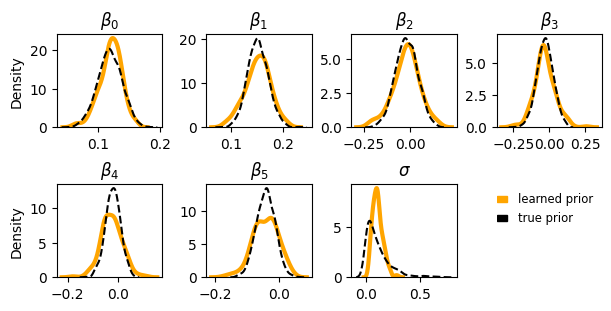

In [14]:
plot_priors_flow(prior_samples, true_values["mu"], true_values["sigma"], true_values["nu"])

## Method: Hyperparameter Learning
[//]: # (-.- .tabset)

### Method specification
+ PriorSamples($\lambda = (\mu_k, \sigma_k, \nu)$):
\begin{align*}
\{\beta_k\}_s &\sim \text{Normal}(\mu_k, \exp\{\sigma_k\})\\
\{s\}_s &\sim \text{Exponential}(\nu)
\end{align*}
+ Generator($\beta_k, s$):
\begin{align*}
\{\theta_i\}_s &= \{\beta_k\}_s \times X_i\\
\bar{s} &= \frac{1}{M} \sum_{i=1}^M \{s\}_s\\
\{y_i\}_s &\sim \text{Normal}(\{\theta_i\}_s, \bar{s})\\
\end{align*}
+ Targets($\{y_i\}_s$):
\begin{align*}
\{\bar{y}_{g}\}_s &= \frac{1}{N_{g}} \sum_{i=1}^{N_{g}} \{y_i\}_s \quad \text{ for } g = 1,\ldots,6\\
\{\Delta_{eff}\}_s &= \{\bar{y}_{g1}\}_s - \{\bar{y}_{g2}\}_s \quad \text{ for } g1 = 3,4,5 \text{ and } g2 = 0,1,2\\
\{R^2\}_s &= \frac{Var(\{\theta_i\}_s)}{Var(\{y_i\}_s)} 
\end{align*}
+ Elicits($\{\bar{y}_{g}\}_s, \{\Delta_{eff}\}_s, \{R^2\}_s$)
\begin{align*}
\text{Quantile-based:} \quad &Q_p^{g} = Q_{p}^{g} \{y_i\}_s \quad \text{ for } g = 1,\ldots, 6, p = 0.1, \ldots, 0.9\\
\text{Quantile-based:} \quad &Q_p^{eff} = Q_{p}^{eff} \{\Delta_{eff}\}_s \quad \text{ for } eff = 1,2,3; p = 0.1, \ldots, 0.9\\
\text{Histogram-based:} \quad &\{R^2\}_s =\{R^2\}_s 
\end{align*}

### User specification

#### Setting hyperparameter for the learning algorithm

In [15]:
# -.-|m { input: true, output_error: false, input_fold: show }

# setting of hyperparameter of learning algorithm
user_config = dict(                    
        B = 2**8,                          
        rep = 200,                         
        epochs = 300,                      
        view_ep = 30,
        lr_decay = True,
        lr0 = 0.1, 
        lr_min = 0.0001, 
        loss_dimensions = "m,n:B",   
        loss_discrepancy = "energy", 
        loss_scaling = "unscaled",         
        method = "hyperparameter_learning"  
        )

#### Define the design matrix

In [16]:
# construct design matrix
X =  pa.dmatrix("a*b", pa.balanced(a = 2, b = 3, repeat = 60), return_type="dataframe")
dmatrix = tf.cast(X, dtype = tf.float32)
# extract contrast matrix from design matrix (for allocating observations to groups)
cmatrix = dmatrix[0:dmatrix.shape[1], :]

print(X)

     Intercept  a[T.a2]  b[T.b2]  b[T.b3]  a[T.a2]:b[T.b2]  a[T.a2]:b[T.b3]
0          1.0      0.0      0.0      0.0              0.0              0.0
1          1.0      0.0      1.0      0.0              0.0              0.0
2          1.0      0.0      0.0      1.0              0.0              0.0
3          1.0      1.0      0.0      0.0              0.0              0.0
4          1.0      1.0      1.0      0.0              1.0              0.0
..         ...      ...      ...      ...              ...              ...
355        1.0      0.0      1.0      0.0              0.0              0.0
356        1.0      0.0      0.0      1.0              0.0              0.0
357        1.0      1.0      0.0      0.0              0.0              0.0
358        1.0      1.0      1.0      0.0              1.0              0.0
359        1.0      1.0      0.0      1.0              0.0              1.0

[360 rows x 6 columns]


#### Setup the 'ideal agent'
Define an 'arbitrary' ground truth for the hyperparameter values for method validation.

In [17]:
# true hyperparameter values for ideal_expert
true_values = dict()
true_values["mu"] = [0.12, 0.15, -0.02, -0.03, -0.02, -0.04]
true_values["sigma"] = [0.02, 0.02, 0.06, 0.06, 0.03, 0.03]
true_values["nu"] = 9.

# model parameters
parameters_dict = dict()
for i in range(6):
    parameters_dict[f"beta_{i}"] = {
            "family":  Normal_unconstrained(),
            "true": tfd.Normal(true_values["mu"][i], true_values["sigma"][i]),
            "initialization": [tfd.Normal(0.,0.1)]*2
            }

exp_dist = Exponential_unconstrained(user_config["rep"])
parameters_dict["sigma"] = {
        "family": exp_dist,
        "true": exp_dist(tf.math.log(true_values["nu"])),
        "initialization": [tfd.Normal(0.,0.1)]
        }

print("True hyperparameter values:")
pp.pprint(true_values)

True hyperparameter values:
{'mu': [0.12, 0.15, -0.02, -0.03, -0.02, -0.04],
 'nu': 9.0,
 'sigma': [0.02, 0.02, 0.06, 0.06, 0.03, 0.03]}


#### Define the data generating model

In [18]:
# -.-|m { input: true, output_error: false, input_fold: show }

# generative model
class GenerativeModel(tf.Module):
    def __call__(self, 
                 parameters, # obligatory: samples from prior distributions; tf.Tensor
                 dmatrix,    # optional: design matrix; tf.Tensor
                 cmatrix,    # optional: contrast matrix; tf.Tensor
                 **kwargs    # obligatory: possibility for further keyword arguments is needed 
                 ):  
        
        # compute linear predictor term
        epred = parameters[:,:,0:6] @ tf.transpose(dmatrix)
        
        # define likelihood
        likelihood = tfd.Normal(
            loc = epred, 
            scale = tf.expand_dims(parameters[:,:,-1], -1))
        
        # sample prior predictive data
        ypred = likelihood.sample()
        
        # compute custom target quantity (here: group-differences)
        samples_grouped = group_obs(ypred, dmatrix, cmatrix)

        # compute mean difference between groups
        effect_list = []
        diffs = [(3,0), (4,1), (5,2)]
        for i in range(len(diffs)):
            # compute group difference
            diff = tf.math.subtract(
                samples_grouped[:, :, :, diffs[i][0]],
                samples_grouped[:, :, :, diffs[i][1]]
            )
            # average over individual obs within each group
            diff_mean = tf.reduce_mean(diff, axis=2)
            # collect all mean group differences
            effect_list.append(diff_mean)

        mean_effects = tf.stack(effect_list, axis=-1)
        
        return dict(likelihood = likelihood,      # obligatory: likelihood; callable
                    ypred = ypred,                # obligatory: prior predictive data
                    epred = epred,                # obligatory: samples from linear predictor
                    mean_effects = mean_effects   # optional: custom target quantity
                    )

#### Specify the target quantities and the elicitation technique

In [19]:
 # define a custom function using the output from the generative model   
def custom_r2(ypred, epred, **kwargs):
    return tf.math.divide(tf.math.reduce_variance(epred, axis = -1), 
                          tf.math.reduce_variance(ypred, axis = -1))

# specify target quantity, elicitation technique and loss combination
t1 = target_config(target="R2", 
                   elicitation="histogram",
                   combine_loss="all",
                   custom_target_function = custom_r2)
t2 = target_config(target="group_means", 
                   elicitation="quantiles", 
                   combine_loss="by-group", 
                   quantiles_specs = (10, 20, 30, 40, 50, 60, 70, 80, 90))
t3 = target_config(target="mean_effects", 
                   elicitation="quantiles",
                   combine_loss="by-group",
                   quantiles_specs = (10, 20, 30, 40, 50, 60, 70, 80, 90))

target_info = target_input(t1, t2, t3)

pp.pprint(target_info)

{'combine_loss': ['all', 'by-group', 'by-group'],
 'custom_target_function': [<function custom_r2 at 0x0000024BFD075800>,
                            None,
                            None],
 'elicitation': ['histogram', 'quantiles', 'quantiles'],
 'internal_loss': [None, None, None],
 'quantiles_specs': [(10, 20, 30, 40, 50, 60, 70, 80, 90),
                     (10, 20, 30, 40, 50, 60, 70, 80, 90)],
 'target': ['R2', 'group_means', 'mean_effects']}


### Simulate from the "ideal" expert

In [20]:
# -.-|m { input: true, output_error: false, input_fold: show }

expert_res_list, prior_pred_res = expert_model(1, user_config["rep"],
                                   parameters_dict, GenerativeModel, target_info,
                                   method = "ideal_expert",
                                   dmatrix = dmatrix,
                                   cmatrix = cmatrix,
                                   dmatrix_fct = dmatrix)

# elicited statistics from the (ideal) expert
expert_res_list.keys()

dict_keys(['R2_hist_0', 'group_means_quant_1', 'mean_effects_quant_2'])

#### Expert predictions

In [21]:
# group means
print(group_stats(prior_pred_res["ypred"], num_groups = 6))
# mean effects
print("mean effects:")
print(np.round(tf.reduce_mean(prior_pred_res["mean_effects"],(0,1)),2))

+-------+------+------+
| group | mean | std  |
+-------+------+------+
|  gr_0 | 0.12 | 0.02 |
|  gr_1 | 0.1  | 0.07 |
|  gr_2 | 0.09 | 0.06 |
|  gr_3 | 0.27 | 0.03 |
|  gr_4 | 0.22 | 0.07 |
|  gr_5 | 0.19 | 0.07 |
+-------+------+------+
mean effects:
[0.15 0.12 0.11]


C:\Users\flobo\MakeMyPrior\MakeMyPrior\helper_functions.py:417: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels(["r","new: deep","new: standard","new: shallow","rep: deep","rep: standard","rep: shallow"])


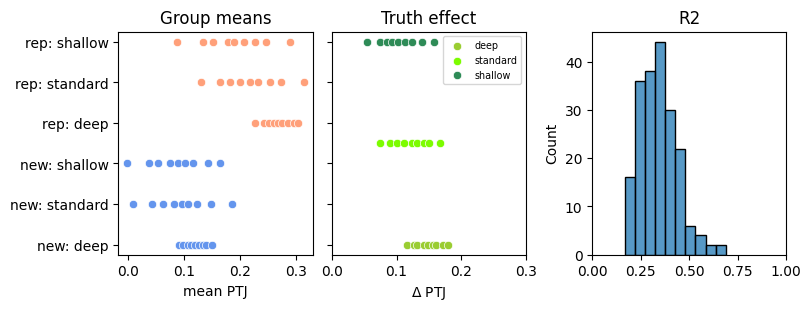

In [22]:
# plot expert predictions
plot_expert_preds(expert_res_list)

### Learn the prior distributions

In [23]:
res_dict = trainer(expert_res_list, user_config["B"], user_config["rep"],
                   parameters_dict, user_config["method"], GenerativeModel,
                   target_info, user_config, loss_balancing = True, save_vals = ["prior_preds"],
                   dmatrix = dmatrix, cmatrix = cmatrix, dmatrix_fct = dmatrix)

epoch_time: 462.108ms
Epoch: 0, loss: 0.74886, lr: 0.100000
epoch_time: 105.835ms
Epoch: 30, loss: 0.05988, lr: 0.053144
epoch_time: 104.903ms
Epoch: 60, loss: 0.01880, lr: 0.028243
epoch_time: 109.590ms
Epoch: 90, loss: 0.02891, lr: 0.015009
epoch_time: 103.867ms
Epoch: 120, loss: 0.01400, lr: 0.007977
epoch_time: 103.787ms
Epoch: 150, loss: 0.02049, lr: 0.004239
epoch_time: 112.480ms
Epoch: 180, loss: 0.01503, lr: 0.002253
epoch_time: 108.481ms
Epoch: 210, loss: 0.01145, lr: 0.001197
epoch_time: 108.643ms
Epoch: 240, loss: 0.01789, lr: 0.000636
epoch_time: 108.552ms
Epoch: 270, loss: 0.01152, lr: 0.000338


### Results

#### Loss function

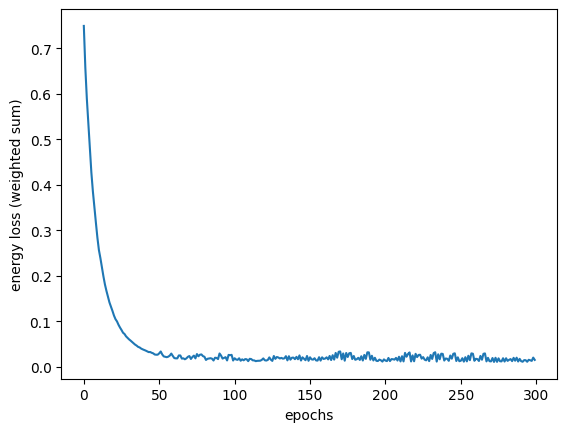

In [24]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(len(res_dict["loss_info"])), res_dict["loss_info"]) 
plt.xlabel("epochs")
plt.ylabel("energy loss (weighted sum)")
plt.show()

#### Summary of hyperparameter values

In [25]:
true_vals = [j for i in zip(true_values["mu"],true_values["sigma"]) for j in i]
true_vals += [true_values["nu"]]

tab, avg_res = print_restab(method = "hyperparameter_learning", 
                             num_vars = 13, 
                             res = res_dict["hyperparam_info"], 
                             start = 10, 
                             precision = 3, 
                             true_values = true_vals)
tab

var_name,pred mean,pred std,true,err
loc_0,0.121,0.004,0.12,0.001
scale_0,0.023,0.0,0.02,0.003
loc_1,0.149,0.004,0.15,0.001
scale_1,0.02,0.0,0.02,0.0
loc_2,-0.024,0.005,-0.02,0.004
scale_2,0.06,0.0,0.06,0.0
loc_3,-0.032,0.008,-0.03,0.002
scale_3,0.06,0.0,0.06,0.0
loc_4,-0.028,0.005,-0.02,0.008
scale_4,0.027,0.0,0.03,0.003


#### Learned prior distributions

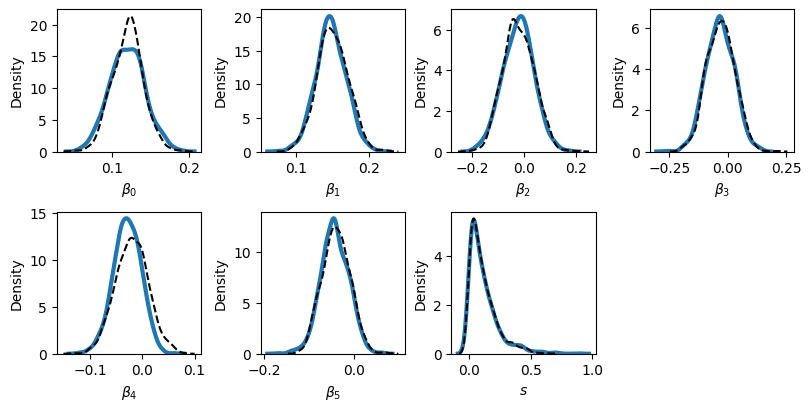

In [26]:
plot_priors_hyp(avg_res, true_values)